In [1]:
import ml_collections
import copy
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from os import path as pt
import pickle
from torch.utils.data import DataLoader, TensorDataset
from src.evaluation.summary import full_evaluation
from src.utils import set_seed, save_obj, load_obj

In [2]:
with open("./data/ref_log_return.pkl", "rb") as f:
    loaded_array = pickle.load(f)
train_log_return = torch.tensor(loaded_array)
print(train_log_return.shape)

with open("./data/ref_price.pkl", "rb") as f:
    loaded_array = pickle.load(f)
train_init_price = torch.tensor(loaded_array)
print(train_init_price.shape)

torch.Size([8937, 24, 3])
torch.Size([8937, 1, 3])


### Generative models for time series generation

In [3]:
# Load configuration dict
config_dir = 'configs/configPCF.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
set_seed(config.seed)

if (config.device ==
        "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)
else:
    config.update({"device": "cpu"}, allow_val_change=True)
    
class XYDataset(TensorDataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.shape = X.shape

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [4]:
perm_idx = torch.randperm(train_log_return.shape[0])
train_size = int(0.8*train_log_return.shape[0])

cv_training_data = train_log_return[perm_idx[:train_size]].to(config.device).to(torch.float)
cv_init_price = train_init_price[perm_idx[:train_size]].to(config.device).to(torch.float)
cv_validation_data = train_log_return[perm_idx[train_size:]].to(config.device).to(torch.float)
cv_val_init_price = train_init_price[perm_idx[train_size:]].to(config.device).to(torch.float)

In [5]:
# Load the dataset
training_set = TensorDataset(cv_init_price, cv_training_data)

train_dl = DataLoader(
    training_set,
    batch_size=config.batch_size,
    shuffle=True
)

config.input_dim = cv_training_data[0][0].shape[-1]

In [6]:
# Load the dataset
testing_set = TensorDataset(cv_val_init_price, cv_validation_data)

test_dl = DataLoader(
    testing_set,
    batch_size=config.batch_size,
    shuffle=True
)

config.input_dim = cv_validation_data[0][0].shape[-1]

### Generative model

Here we construct a generator and a discriminator for this task. Both the generator and discriminator takes as input the time series. Then we have the training algorithm TailGANTrainer.

In [6]:
# from src.baselines.networks.discriminators import Discriminator
# from src.baselines.networks.generators import Generator
# from src.baselines.TailGAN import *


# from src.networks.discriminators import LSTMDiscriminator
# from src.networks.generators import LSTMGenerator
# from src.PCFGAN.PCFGAN import PCFGANTrainer

In [7]:
from src.utils import loader_to_tensor
from functools import partial
from src.utils import to_numpy, AddTime
import ksig
# from src.ksig_copy.ksig import RBFKernel, SignatureKernel

def Sig_mmd_small(X, Y, depth):
    # convert torch tensor to numpy
    N, L, C = X.shape
    N1, _, C1 = Y.shape
    X = torch.cat([torch.zeros((N, 1, C)).to(X.device), X], dim=1)
    Y = torch.cat([torch.zeros((N1, 1, C1)).to(X.device), Y], dim=1)
    X = to_numpy(AddTime(X))
    Y = to_numpy(AddTime(Y))
    n_components = 100
    static_kernel = ksig.static.kernels.RBFKernel()
    # an RBF base kernel for vector-valued data which is lifted to a kernel for sequences
    sig_kernel = ksig.kernels.SignatureKernel(depth, static_kernel=static_kernel)
    # Nystroem features with an RBF base kernel

    K_XX = sig_kernel(X)  # K_XX has shape (10, 10)
    K_XY = sig_kernel(X, Y)
    K_YY = sig_kernel(Y)
    m = K_XX.shape[0]
    diag_X = np.diagonal(K_XX)
    diag_Y = np.diagonal(K_YY)

    Kt_XX_sums = K_XX.sum(axis=1) - diag_X
    Kt_YY_sums = K_YY.sum(axis=1) - diag_Y
    K_XY_sums_0 = K_XY.sum(axis=0)

    Kt_XX_sum = Kt_XX_sums.sum()
    Kt_YY_sum = Kt_YY_sums.sum()
    K_XY_sum = K_XY_sums_0.sum()
    mmd2 = (Kt_XX_sum + Kt_YY_sum) / (m * (m - 1))
    mmd2 -= 2 * K_XY_sum / (m * m)

    return torch.tensor(mmd2)

class Loss(nn.Module):
    def __init__(
        self,
        name,
        reg=1.0,
        transform=lambda x: x,
        threshold=10.0,
        backward=False,
        norm_foo=lambda x: x,
    ):
        super(Loss, self).__init__()
        self.name = name
        self.reg = reg
        self.transform = transform
        self.threshold = threshold
        self.backward = backward
        self.norm_foo = norm_foo

    def forward(self, x_fake):
        self.loss_componentwise = self.compute(x_fake)
        return self.reg * self.loss_componentwise.mean()

    def compute(self, x_fake):
        raise NotImplementedError()

    @property
    def success(self):
        return torch.all(self.loss_componentwise <= self.threshold)

class Sig_MMD_loss(Loss):
    def __init__(self, x_real, depth, **kwargs):
        super(Sig_MMD_loss, self).__init__(**kwargs)
        self.x_real = x_real
        self.depth = depth

    def compute(self, x_fake):
        return Sig_mmd_small(self.x_real, x_fake, self.depth)

test_metrics = {
    "Sig_mmd": partial(Sig_MMD_loss, name="Sig_mmd", depth=4),
}

def get_standard_test_metrics(x: torch.Tensor, **kwargs):
    """Initialise list of standard test metrics for evaluating the goodness of the generator."""
    test_metrics_list = [
        test_metrics["Sig_mmd"](x, depth=4),
    ]
    return test_metrics_list

x_real_train = loader_to_tensor(train_dl).to(config.device)
x_real_test = loader_to_tensor(test_dl).to(config.device)

test_metrics_train = get_standard_test_metrics(x_real_train)
test_metrics_test = get_standard_test_metrics(x_real_test)

In [8]:
%load_ext autoreload

In [ ]:
%autoreload 2
import src.networks.discriminators
import src.networks.generators
# import src.networks.generators3
import src.PCFGAN.PCFGAN
LSTMDiscriminator = src.networks.discriminators.LSTMDiscriminator
LSTMGenerator = src.networks.generators.LSTMGenerator
# LSTMGenerator = src.networks.generators3.LSTMGenerator
PCFGANTrainer = src.PCFGAN.PCFGAN.PCFGANTrainer

### Initialize the generator, discriminator and the trainer

In [ ]:
# generator = LSTMGenerator(input_dim= 3,output_dim= 3,hidden_dim= 64,n_layers= 2)
generator = LSTMGenerator(input_dim= 3,output_dim= 3,hidden_dim= 64,n_layers= 2)
# input_dim= 3,output_dim= 3,hidden_dim= 64,n_layers= 2  ######## 3 correct?
# discriminator = LSTMDiscriminator(config)
trainer = PCFGANTrainer(
            G=generator,
            test_metrics_train=test_metrics_train,
            # test_metrics_test=test_metrics_test,
            test_metrics_test=test_metrics_train,
            train_dl=train_dl,
            batch_size=config.batch_size,
            n_gradient_steps=config.steps,
            config=config
        )


### Model training and saving

  0%|          | 1/3000 [00:11<9:15:28, 11.11s/it]

Learning Rate: 0.0009699999999999999


 17%|█▋        | 501/3000 [09:44<1:11:42,  1.72s/it]

Learning Rate: 0.0009408999999999999


 33%|███▎      | 1001/3000 [19:13<58:59,  1.77s/it] 

Learning Rate: 0.0009126729999999999


 50%|█████     | 1501/3000 [29:15<45:33,  1.82s/it]

Learning Rate: 0.0008852928099999999


 67%|██████▋   | 2001/3000 [39:23<30:39,  1.84s/it]

Learning Rate: 0.0008587340256999998


 83%|████████▎ | 2501/3000 [49:37<15:11,  1.83s/it]

Learning Rate: 0.0008329720049289999


100%|██████████| 3000/3000 [1:00:40<00:00,  1.21s/it]


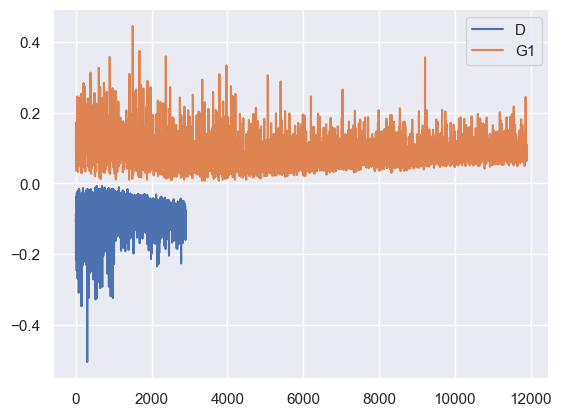

0

In [11]:
trainer.fit(config.device)
save_obj(trainer.G.state_dict(), './sample_submission_bundle_PCF/model_dict.pkl')

### Synthetic data generation

In [12]:
g_state_dict = load_obj('./sample_submission_bundle_PCF/model_dict.pkl')

generator.load_state_dict(g_state_dict)

generator.eval()

eval_size = 1600

with torch.no_grad():
    fake_data = generator(batch_size = eval_size, device=config.device, n_lags=config.n_lags)
    
print(fake_data.shape)
# Save the data
save_obj(fake_data, './sample_submission_bundle_PCF/fake_log_return.pkl')

torch.Size([1600, 24, 3])


0

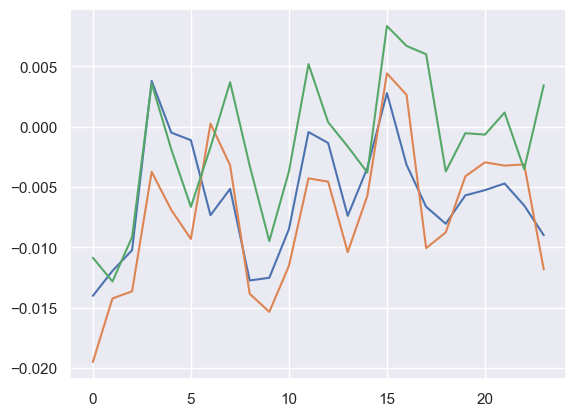

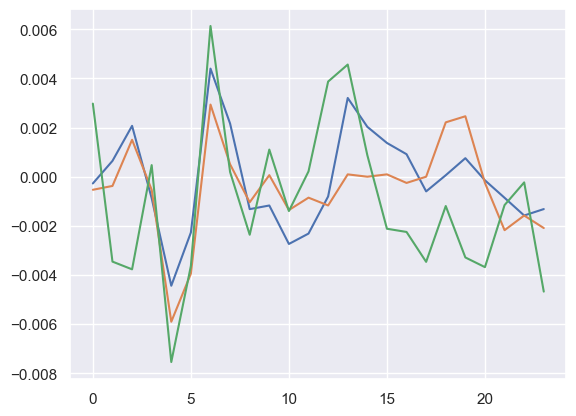

In [13]:
poiu = 9
copy_fake = fake_data.clone()
copy_fake = copy_fake.detach().cpu().numpy()
plt.plot(copy_fake[poiu,:,0])
plt.plot(copy_fake[poiu,:,1])
plt.plot(copy_fake[poiu,:,2])
plt.show()

copy_real = cv_validation_data.clone()
copy_real = copy_real.detach().cpu().numpy()
plt.plot(copy_real[poiu,:,0])
plt.plot(copy_real[poiu,:,1])
plt.plot(copy_real[poiu,:,2])
plt.show()

### Model evaluation

We compute the performance of our model by first generating the price process, apply the prespecified trading strategies and compare the resulting PnL process using the real and fake data.

In [14]:
from src.evaluation.strategies import log_return_to_price

config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))

fake_prices = log_return_to_price(fake_data[:eval_size], cv_val_init_price[:eval_size])
cv_val = log_return_to_price(cv_validation_data[:eval_size], cv_val_init_price[:eval_size])

all_positive = (fake_prices > 0).all()
if not all_positive:
    raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}

# Do final evaluation
num_strat = 4

# with torch.no_grad():
#     for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
#         subres_dict = full_evaluation(fake_prices, cv_val, eval_config, strat_name = strat_name)
#         for k in res_dict:
#             res_dict[k] += subres_dict[k] / num_strat
        
# for k, v in res_dict.items():
#     print(k, v)


In [ ]:
# fake_data[:, -1, :].shape
# print(torch.mean(fake_data[:, 0, :],dim=0))
# print(torch.mean(fake_data[:, -1, :],dim=0))
# testtest1 = torch.mean(fake_data[:, 0, :],dim=0) - torch.mean(fake_data[:, -1, :],dim=0)

# print(torch.mean(cv_validation_data[:, 0, :],dim=0))
# print(torch.mean(cv_validation_data[:, -1, :],dim=0))
# testtest2 = torch.mean(cv_validation_data[:, 0, :],dim=0) - torch.mean(cv_validation_data[:, -1, :],dim=0)

# print(testtest1)
# print(testtest2)
# print(torch.sum(torch.abs(testtest1-testtest2)))


tensor([ 0.0035, -0.0032, -0.0058], device='cuda:0')
tensor([ 0.0009, -0.0061, -0.0053], device='cuda:0')
tensor([-0.0001, -0.0001, -0.0002], device='cuda:0')
tensor([-2.3570e-05,  1.5273e-05, -6.6821e-05], device='cuda:0')
tensor([ 0.0026,  0.0030, -0.0005], device='cuda:0')
tensor([-9.4376e-05, -1.3803e-04, -1.3982e-04], device='cuda:0')
tensor(0.0062, device='cuda:0')


In [ ]:
# with torch.no_grad():
#     for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
#         subres_dict = full_evaluation(fake_prices, cv_val, eval_config, strat_name = strat_name)
#         for k in res_dict:
#             res_dict[k] += subres_dict[k] / num_strat
        
# for k, v in res_dict.items():
#     print(k, v)222222dfd

In [15]:
import time

with torch.no_grad():
    res_dict_full = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}
    for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
        res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}
        t1 = time.time()
        subres_dict = full_evaluation(fake_prices, cv_val, eval_config, strat_name = strat_name)
        t2 = time.time()
        for k in res_dict:
            res_dict[k] += subres_dict[k] / num_strat
            res_dict_full[k] += subres_dict[k] / num_strat
        print(strat_name)
        for k, v in res_dict.items():
            print(k, v)
        print("time", t2-t1)
    for k, v in res_dict_full.items():
            print(k, v)

equal_weight
var_mean 0.01814291439950466
es_mean 0.020908767357468605
max_drawback_mean 0.011605794541537762
cumulative_pnl_mean 0.01575719378888607
time 24.88739776611328
mean_reversion
var_mean 0.022494247183203697
es_mean 0.02453913353383541
max_drawback_mean 0.009499077685177326
cumulative_pnl_mean 0.010006698779761791
time 204.6145167350769
trend_following
var_mean 0.0001020144991343841
es_mean 0.000249413336860016
max_drawback_mean 0.0006648001726716757
cumulative_pnl_mean 0.001130320830270648
time 132.06561708450317
vol_trading
var_mean 0.016765492036938667
es_mean 0.01806051656603813
max_drawback_mean 0.008139430545270443
cumulative_pnl_mean 0.009224845096468925
time 176.26097106933594
var_mean 0.05750466811878141
es_mean 0.06375783079420216
max_drawback_mean 0.029909102944657207
cumulative_pnl_mean 0.036119058495387435


2000
500


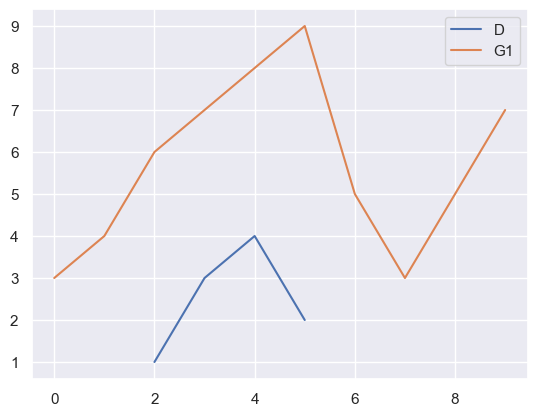

In [ ]:
# testtest = [1,2,3,4,5]
# print(testtest[:5])
# print(testtest[5-1])
import time

print(len(range(0, 2000)))
print(len(range(0, 2000, 4)))

D_loss_copy = torch.tensor([1,1,1,3,4,2])
G_loss_copy = torch.tensor([1,1,3,4,6,7,8,9,5,3,5,7])
plt.plot(range(len(D_loss_copy))[2:], D_loss_copy[2:], label='D')
plt.plot(range(len(G_loss_copy[2:])), G_loss_copy[2:], label='G1')
plt.legend(loc="upper right")
plt.show()

In [16]:
import sample_submission_bundle_PCF.model as test_model
import torch

DEVICE = "cuda"
gen_test = test_model.init_generator()
with torch.no_grad():
    fake_data = gen_test(batch_size = 1800, device=DEVICE, n_lags=24)

print(fake_data.shape)


c:\Users\dawid\Desktop\Python stuff\ICAIF_Competition\testing_models\PCFGAN_main\sample_submission_bundle_PCF\model.py
Initialisation of the model.
Loading the model.
torch.Size([1800, 24, 3])


In [ ]:
# import time
# from src.evaluation.strategies import log_return_to_price

# config_dir = 'src/evaluation/config.yaml'
# with open(config_dir) as file:
#     eval_config = ml_collections.ConfigDict(yaml.safe_load(file))

# eval_size = 1700

# fake_prices = log_return_to_price(fake_data[:eval_size], cv_val_init_price[:eval_size])
# cv_val = log_return_to_price(cv_validation_data[:eval_size], cv_val_init_price[:eval_size])

# all_positive = (fake_prices > 0).all()
# if not all_positive:
#     raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

# res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}

# # Do final evaluation
# num_strat = 4

# with torch.no_grad():
#     res_dict_full = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}
#     for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
#         res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}
#         t1 = time.time()
#         subres_dict = full_evaluation(fake_prices, cv_val, eval_config, strat_name = strat_name)
#         t2 = time.time()
#         for k in res_dict:
#             res_dict[k] += subres_dict[k] / num_strat
#             res_dict_full[k] += subres_dict[k] / num_strat
#         print(strat_name)
#         for k, v in res_dict.items():
#             print(k, v)
#         print("time", t2-t1)
#     for k, v in res_dict_full.items():
#             print(k, v)

equal_weight
var_mean 0.001181394443847239
es_mean 0.003034849651157856
max_drawback_mean 0.005813647527247667
cumulative_pnl_mean 0.009453111328184605
time 24.801985263824463
mean_reversion
var_mean 0.001016990514472127
es_mean 0.0005158059648238122
max_drawback_mean 0.0034837706480175257
cumulative_pnl_mean 0.0040437267161905766
time 183.7288966178894
trend_following
var_mean 0.00011381621879991144
es_mean 9.548205707687885e-05
max_drawback_mean 0.0007204872672446072
cumulative_pnl_mean 0.001055404543876648
time 134.5769703388214
vol_trading
var_mean 0.0005513268988579512
es_mean 0.0019007474184036255
max_drawback_mean 0.003418177366256714
cumulative_pnl_mean 0.004658677149564028
time 204.05477285385132
var_mean 0.0028635280759772286
es_mean 0.005546885091462173
max_drawback_mean 0.013436082808766514
cumulative_pnl_mean 0.019210919737815857
